In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import pyvips
from typing import Any, Dict, List

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
        color = np.array([30/255, 144/255, 255/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def get_contours(mask):
    if len(mask.shape) > 2:
        mask = np.squeeze(mask, 0)
    mask = mask.astype(np.uint8)
    mask *= 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    effContours = []
    total_area = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > MIN_AREA:
            effContours.append(c)
            total_area += area
    return effContours, total_area

def contour_to_points(contour):
    pointsNum = len(contour)
    contour = contour.reshape(pointsNum, -1).astype(np.float32)
    points = [point.tolist() for point in contour]
    return points

def generate_json(binary_masks):
    """Generate a JSON file from binary mask tensor.

    Args:
        binary_masks: Binary mask tensor of shape [N, H, W].
        labels: List of labels for each mask.
        image_size: Tuple of (height, width) for the image size.
        image_path: Path to the image file (optional).

    Returns:
        A dictionary representing the JSON file.
    """
    json_dict = {
        "annotation": list(),
        "information": dict()
    }

    # Loop through the masks and add them to the JSON dictionary
    for mask in binary_masks:
        effContours, area = get_contours(mask)

        for effContour in effContours:
            points = contour_to_points(effContour)
            shape_dict = {
                "name": "tissue",
                "type": "polygon",
                "partOfGroup": "HCC",
                "coordinates": points,
            }

            json_dict["annotation"].append(shape_dict)
            json_dict["information"]["Tissue area"] = area

    return json_dict

In [9]:
image = cv2.imread('./out/CSY-A-8a_TRI.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(2904, 3174, 3)

In [10]:
predictor.set_image(image)

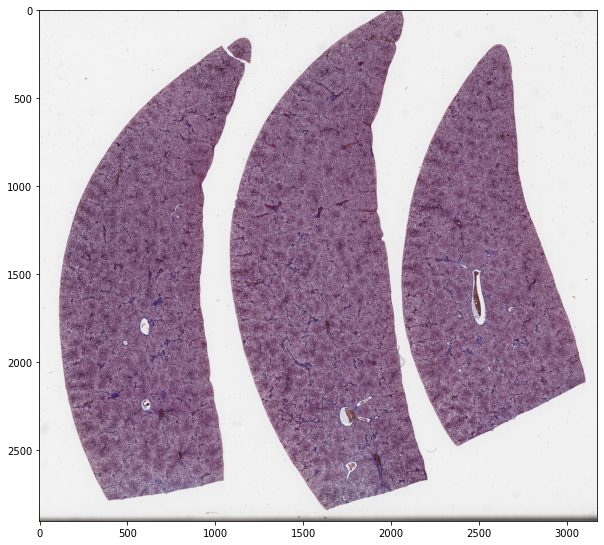

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [12]:
from contour_prompt import getprompt
image_path='../images/CSY-A-8a_TRI.svs'
print(getprompt(image_path))
input_boxes = torch.tensor(getprompt(image_path), device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

Convert completed
[[0, 2869, 3174, 2904], [114, 202, 1171, 2790], [2060, 193, 3109, 2480], [1070, 156, 1209, 305], [1084, 0, 2209, 2843]]
Convert completed


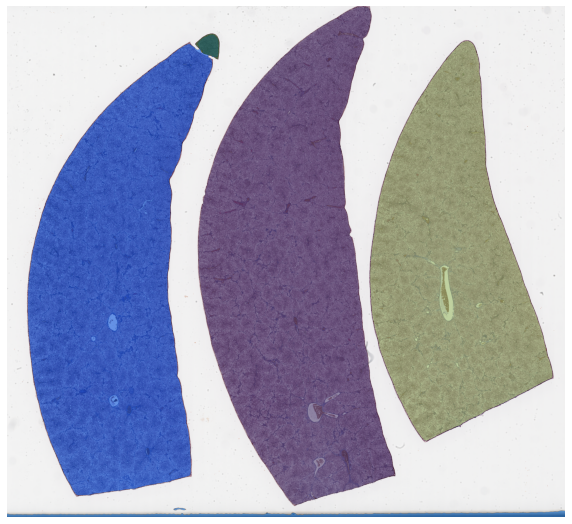

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
'''
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())'''
plt.axis('off')
plt.savefig('./test.png')
plt.show()